# Examples of the Metropolis-Hastings algorithm

This notebook explores the Metropolis-Hastings algotihm. I use it to learn about the basics and create examples of it.

The different sections will explore different levels of difficulty, starting from the basics. As I work on it, I will add more and more complexity to the examples.


In [30]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scipy.stats as stats

## The basics

From ChatGPT:

1. **Define the Target Distribution:** You need to have a target probability distribution, $ P(x) $, from which you want to sample. Often, $ P(x) $ is known only up to a normalization factor.

2. **Choose a Proposal Distribution:** Select a proposal distribution, $ Q(x'|x) $, which suggests a new state $ x' $ given the current state $ x $. This distribution should be easy to sample from. A common choice is a symmetric distribution like a Gaussian centered at $ x $.

3. **Initialize:** Start with an initial guess $ x_0 $ for the state of the system.

4. **Iterate Through the Following Steps:**
   - **Sample a Candidate:** Generate a candidate point $ x' $ using the proposal distribution $ Q(x'|x) $.
   - **Calculate the Acceptance Ratio:** Compute the acceptance ratio, $ A(x'|x) $, which is a measure of how much more likely the new state is compared to the current state. It's given by $$A(x'|x) = \min\left(1, \frac{P(x')Q(x|x')}{P(x)Q(x'|x)}\right).$$ If $Q$ is symmetric, this simplifies to $ \min\left(1, \frac{P(x')}{P(x)}\right) $.

   - **Accept or Reject the Candidate:** Generate a uniform random number $ u $ between 0 and 1. If $ u < A(x'|x) $, accept $ x' $ as the new state; otherwise, keep $ x $.

5. **Repeat:** Repeat the iteration process (step 4) for as many steps as necessary to adequately explore the state space.

6. **Convergence:** After a 'burn-in' period, the states $ x $ sampled by this algorithm can be treated as samples from $ P(x) $. The number of iterations required for convergence depends on the problem and should be assessed using diagnostic methods.

7. **Analysis:** Once you have a collection of samples, you can estimate various properties of the target distribution, like mean, variance, or even create histograms to approximate the distribution.

Remember, the key to the Metropolis-Hastings algorithm is the balance between exploring new states and accepting states that are more probable under the target distribution. The efficiency of the algorithm greatly depends on the choice of the proposal distribution and the nature of the target distribution.

In [123]:
# Define the Metropolis-Hastings algorithm. From the above explanation, this function considers the execution since step 4.
def metropolis_hastings(x_init, iterations, stepsize, proposal_dist, target_dist, verbose=0):
    # Initialize a time counter
    t = time.time()

    # A list to store the samples
    samples = [x_init]

    # Step 4: Iterate through the following steps
    for i in range(iterations):
        # Sample a candidate
        x_candidate = proposal_dist(samples[-1], stepsize)

        # Calculate the acceptance ratio
        A = min(1, target_dist(x_candidate) * proposal_dist(x_candidate, stepsize) / (target_dist(samples[-1]) * proposal_dist(samples[-1], stepsize)))

        # Accept or reject the candidate
        u = np.random.rand()
        if u < A:
            # Accept the candidate and append the candidate
            samples.append(x_candidate)
        else:
            # Reject the candidate and append the last sample in the list
            samples.append(samples[-1])

    # Update the time counter
    t = time.time() - t

    # Print the time it took to run the algorithm
    if verbose > 0:
        print('Time to run the algorithm: {} seconds'.format(t))

    return samples

## Example 1: Sampling from a Gaussian distribution
Our target distribution $P(x)$ is a standard normal distribution (mean 0, standard deviation 1).
The goal is to obtain samples from the target distribution $P(x)$ using the Metropolis-Hastings algorithm.

In [138]:
# Define the target distribution as a standard normal distribution
def target_distribution(x):
    return stats.norm.pdf(x, 0, 1)

### Example 1.a
Our proposal distribution $Q(x'|x)$ is a normal distribution centered at the current state $x$.

In [139]:
# Define the proposal distribution as a normal distribution centered at the current state with a std of 1
def proposal_distribution(x, stepsize):
    return np.random.normal(x, stepsize)

Time to run the algorithm: 2.1600489616394043 seconds


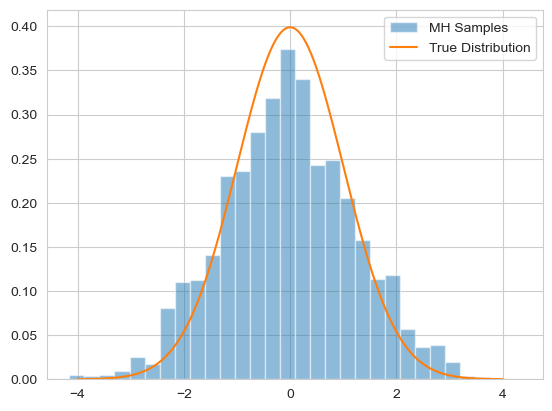

In [140]:
# Run the Metropolis-Hastings algorithm considering the following parameters
x_0 = np.random.normal(0, 1)
iterations = 10000
stepsize = 5.

# Run the algorithm
samples = metropolis_hastings(x_0, iterations, stepsize, proposal_distribution, target_distribution, verbose=1)

# Plot the results
plt.hist(samples, bins=30, density=True, alpha=0.5, label='MH Samples')
x = np.linspace(-4, 4, 1000)
plt.plot(x, stats.norm.pdf(x, 0, 1), label='True Distribution')
plt.legend()

### Example 1.b
We now try another proposal distribution $Q(x'|x)$, which is a uniform distribution centered at the current state $x$.

In [141]:
# Define the proposal distribution as a uniform distribution centered at the current state with a std of 1
def proposal_distribution(x, stepsize):
    return np.random.uniform(x - stepsize, x + stepsize)

Time to run the algorithm: 2.5744588375091553 seconds


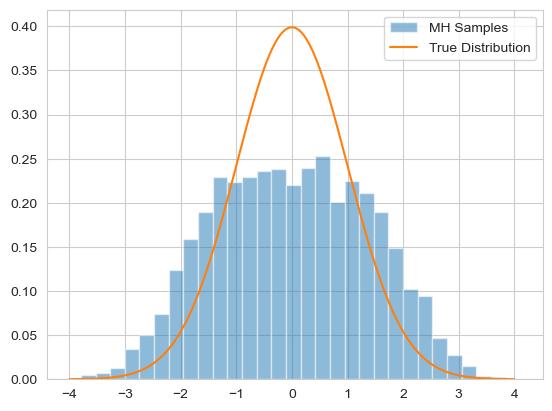

In [142]:
# Run the Metropolis-Hastings algorithm considering the following parameters
x_0 = np.random.normal(0, 1)
iterations = 10000
stepsize = 1

# Run the algorithm
samples = metropolis_hastings(x_0, iterations, stepsize, proposal_distribution, target_distribution, verbose=1)
# Plot the results
plt.hist(samples, bins=30, density=True, alpha=0.5, label='MH Samples')
x = np.linspace(-4, 4, 1000)
plt.plot(x, stats.norm.pdf(x, 0, 1), label='True Distribution')
plt.legend()

## Example 2: Empirical target distribution
Our target distribution $P(x)$ is an empirical distribution obtained from a set of samples and then estimated using a Gaussian kernel density estimator.

In [143]:
from scipy.stats import gaussian_kde

class empirical_target_distribution:
    def __init__(self, data):
        self.kde = gaussian_kde(data, bw_method=0.5)

    def __call__(self, x):
        return self.kde.evaluate(x)

(0.0, 0.2)

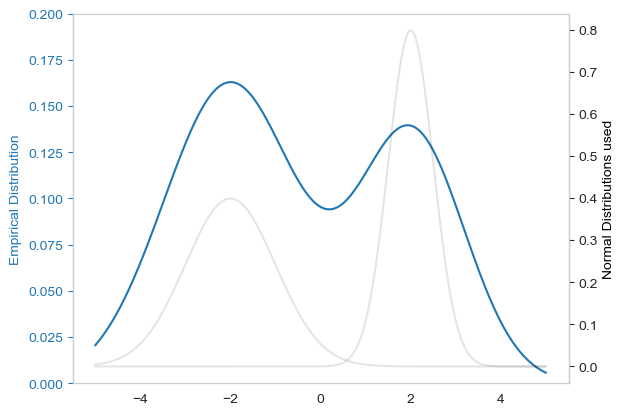

In [144]:
# Generate sample data for empirical distribution
normal_specs = [[-2, 1, 1500], [2, 0.5, 1000]]
data = np.concatenate([np.random.normal(*spec) for spec in normal_specs])

# Create the empirical distribution
target_dist = empirical_target_distribution(data)

# Plot the empirical distribution
x = np.linspace(-5, 5, 1000)
plt.plot(x, target_dist(x))

# make the y ticks font color the same as the line color
ax = plt.gca()
ax.tick_params(axis='y', colors='C0')
ax.yaxis.label.set_color('C0')
ax.spines['left'].set_color('C0')
ax.spines['right'].set_color('C0')

# Y label
plt.ylabel('Empirical Distribution', color='C0')

# PLot also the two normal distributions that were used to generate the data in a subtle way. Use another y-axis for this.
ax2 = ax.twinx()
for spec in normal_specs:
    ax2.plot(x, stats.norm.pdf(x, spec[0], spec[1]), alpha=0.1, color='k')

# Y label second axis
plt.ylabel('Normal Distributions used', color='k')

# Deactivate horizontal grid lines
ax.grid(False)
ax2.grid(False)

# Set the limits of the y-axis
ax.set_ylim(0, 0.2)

### Example 2.a
Our proposal distribution $Q(x'|x)$ is a normal distribution centered at the current state $x$.

In [145]:
# Define the proposal distribution as a normal distribution centered at the current state with a std of 1
def proposal_distribution(x, stepsize):
    return np.random.normal(x, stepsize)

Time to run the algorithm: 4.226632356643677 seconds


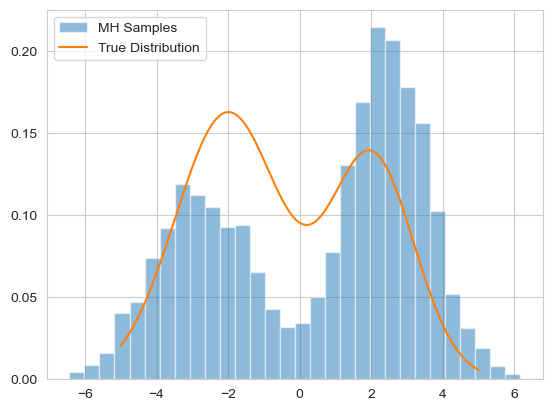

In [146]:
# Run the Metropolis-Hastings algorithm considering the following parameters
x_0 = np.random.normal(0, 1)
iterations = 10000
stepsize = 0.5

# Run the algorithm
samples = metropolis_hastings(x_0, iterations, stepsize, proposal_distribution, target_dist, verbose=1)

# Plot the results
plt.hist(samples, bins=30, density=True, alpha=0.5, label='MH Samples')
x = np.linspace(-5, 5, 1000)
plt.plot(x, target_dist(x), label='True Distribution')
plt.legend()

## Example 3: An adaptive stepsize
As we saw in the previous examples, the choice of the stepsize is crucial for the performance of the algorithm.
However, it is not always easy to choose a good stepsize.
In this example, we will see how we can adapt the stepsize during the execution of the algorithm.

In [149]:
# Redefine the Metropolis-Hastings algorithm to include an adaptive stepsize
def metropolis_hastings_adaptive_stepsize(x_init, iterations, initial_stepsize, proposal_dist, target_dist, verbose=0):
    # Initialize a time counter
    t = time.time()

    # A list to store the samples
    samples = [x_init]


    # Initialize
    stepsize = initial_stepsize

    # Tuning parameters
    target_acceptance_rate = 0.3  # Target acceptance rate
    tune_interval = 100           # Interval to adjust step size
    tune_factor = 1.1             # Factor to adjust step size

    for i in range(iterations):
        x_candidate = proposal_distribution(x_init, stepsize)

        # Calculate the acceptance ratio
        A = min(1, target_dist(x_candidate) * proposal_dist(x_candidate, stepsize) / (target_dist(samples[-1]) * proposal_dist(samples[-1], stepsize)))

        # Accept or reject the candidate
        u = np.random.rand()

        if u < A:
            x_current = x_candidate
            samples.append(x_candidate)
        else:
            samples.append(x_init)

        # Adaptive step size tuning
        if (i + 1) % tune_interval == 0:
            acceptance_rate = np.mean([samples[j] != samples[j-1] for j in range(i-tune_interval+1, i+1)])
            if acceptance_rate < target_acceptance_rate:
                stepsize /= tune_factor
            else:
                stepsize *= tune_factor

    # Update the time counter
    t = time.time() - t

    # Print the time it took to run the algorithm
    if verbose > 0:
        print('Time to run the algorithm: {} seconds'.format(t))


    return samples

### Example 3.a
We reuse the target distribution from example 1

Time to run the algorithm: 2.068195343017578 seconds


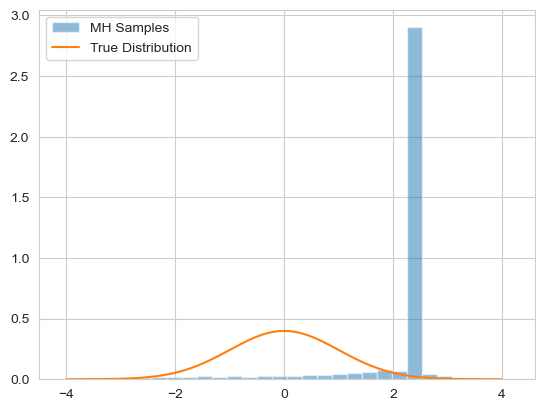

In [150]:
# Target distribution: standard normal distribution
def target_dist(x):
    return stats.norm.pdf(x, 0, 1)

# Run the Metropolis-Hastings algorithm considering the following parameters
x_0 = np.random.normal(0, 1)
iterations = 10000
stepsize = 0.5

# Run the algorithm
samples = metropolis_hastings_adaptive_stepsize(x_0, iterations, stepsize, proposal_distribution, target_dist, verbose=1)

# Plot the results
plt.hist(samples, bins=30, density=True, alpha=0.5, label='MH Samples')
x = np.linspace(-4, 4, 1000)
plt.plot(x, stats.norm.pdf(x, 0, 1), label='True Distribution')
plt.legend()